In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_gdp = pd.read_pickle('gdp_data.pkl')
df_gdp.index = df_gdp['SurveyDate']
df_gdp = df_gdp.drop('SurveyDate', axis=1)

# load shocks

In [3]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
oisfactors

,1M,3M,6M,1Y,2Y,5Y,10Y,Date,ConfFactor1,ConfFactor2,ConfFactor3
Date,,,,,,,,,,,
2002-01-03,0.0125,0.0125,0.0070,0.00500,-0.0050,-0.0105,-0.0140,2002-01-03,1.984610,-2.013147,-0.765204
2002-02-07,0.0050,0.0080,0.0050,0.01250,0.0145,0.0240,0.0210,2002-02-07,0.803178,0.588936,1.714052
2002-03-07,0.0050,0.0000,0.0020,-0.00500,-0.0050,0.0025,0.0025,2002-03-07,0.502155,-0.819328,0.754432
2002-04-04,-0.0075,-0.0125,-0.0100,-0.02250,-0.0300,-0.0240,-0.0230,2002-04-04,-0.944470,-1.100228,-1.087792
2002-05-02,0.0050,0.0200,0.0425,0.07000,0.0725,0.0615,0.0530,2002-05-02,2.389232,4.821021,1.451719
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-08,-0.0018,0.0000,0.0040,-0.00175,-0.0077,-0.0258,-0.0290,2018-03-08,0.332580,-0.231835,-2.799684
2018-04-26,0.0000,0.0000,0.0000,-0.00100,-0.0030,0.0000,0.0030,2018-04-26,0.271545,-0.314816,0.421258
2018-06-14,0.0000,0.0000,0.0000,0.00000,-0.0040,-0.0080,-0.0050,2018-06-14,0.304379,-0.304242,-0.458284


In [4]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)


# some useful functions

In [5]:
def get_diff_dataframe(df):
    for eachcol in df.columns.to_list()[1:]:
        df[eachcol] = df[eachcol].astype(float)  
    return df.groupby(['Source', 'SurveyDate']).mean().sort_index().diff()

In [97]:
def cumSums(results, first_element = 0):
    cumsumCI = np.zeros((8, 3))
    #first estimate c0
    samplesize = 43
    mean = results.params[first_element] 
    cov = results.cov_params()[first_element,first_element]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(43)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(43)
    cumsumCI[0, 0] = lowB
    cumsumCI[0, 1] = mean
    cumsumCI[0, 2] = upB
    #we continue for the other coefficients
    for i in range(first_element+1, first_element+8):
        #get the new mean
        mean = mean + results.params[i]
        #add the variance
        cov = cov + results.cov_params()[i,i]*samplesize
        #add the covariances
        for j in range(first_element, i):
            cov = cov + 2*results.cov_params()[j,i]*samplesize
        upB = mean + 1.96*np.sqrt(cov)/np.sqrt(43)
        lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(43)
        cumsumCI[i-first_element, 0] = lowB
        cumsumCI[i-first_element, 1] = mean
        cumsumCI[i-first_element, 2] = upB

    df = pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
    df = df.sort_index()
    plt.plot(df['Mean'], color='r');
    plt.fill_between(df.index, df['LowerB'], df['Mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['UpperB'], df['Mean'], alpha = 0.1, color='darkslategrey')
    plt.title('GDP');

# transforming SPF GDP data

In [7]:
df = get_diff_dataframe(df_gdp).reset_index()

In [8]:
df.index = df['SurveyDate']
df = df.sort_index()

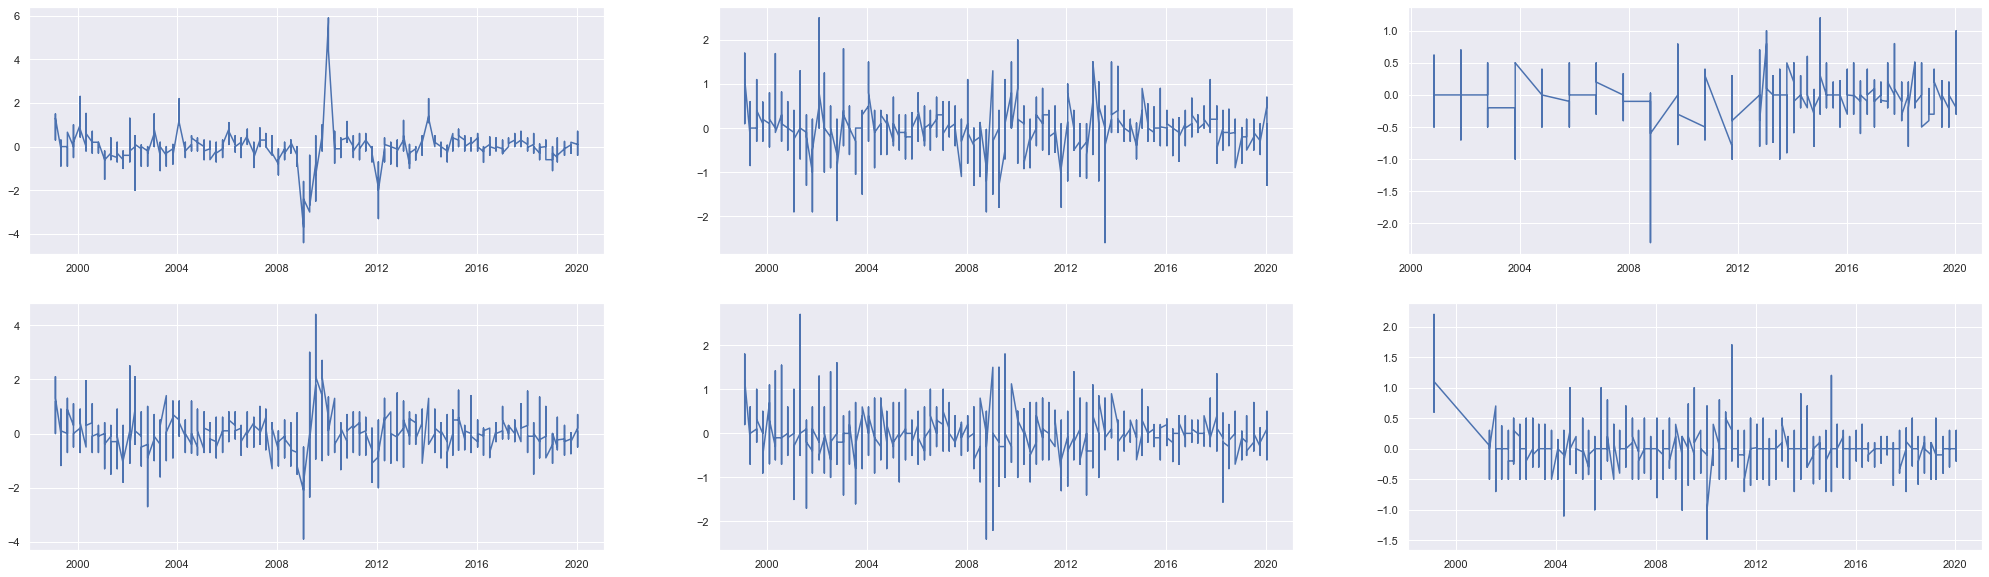

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(35, 10));
axs[0,0].plot(df['Current Year'].dropna().astype(float))
axs[0,1].plot(df['One Year Ahead'].dropna().astype(float))
axs[0,2].plot(df['Two Years Ahead'].dropna().astype(float))
axs[1,0].plot(df['Rolling1'].dropna().astype(float))
axs[1,1].plot(df['Rolling2'].dropna().astype(float))
axs[1,2].plot(df['Longer Term'].dropna().astype(float));

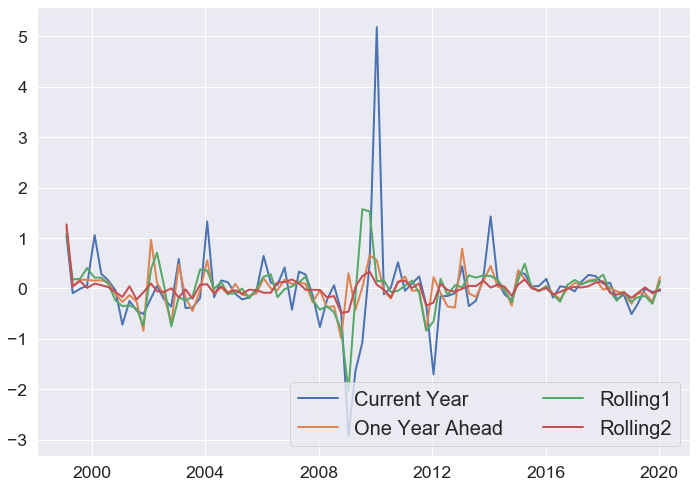

In [10]:
df = df.drop('SurveyDate', axis = 1)
dfmeans = df.groupby('SurveyDate')[['Current Year','One Year Ahead', 'Rolling1', 'Rolling2']].mean()

sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(dfmeans, linewidth=2.0);
plt.legend(list(dfmeans), ncol=2, loc='lower right', fontsize=20);

## GMM framework

In [107]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        rolling1 = endog[:,2]
        rolling2 = endog[:,3]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error1 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        error9 = mp*(rolling1-mp*(c0+c1+c2))
        error10 = mp*(rolling2-mp*(c3+c4+c5+c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.merge_asof(dfmeans, pcdf, left_index=True, right_index = True,
                       direction='backward')
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var])
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
exog = dataols[['D1', 'D2', 'D3', 'D4', var]]
endog = dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']].copy()
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='hac',
                  wargs={'maxlag':4})

w0 = res[1]
inv_weights = np.linalg.inv(w0)

res = model.fit(beta0, maxiter=10,   inv_weights = np.diag(t1), optim_method='nm',   weights_method='hac',
                   wargs={'maxlag':4})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.044430
         Iterations: 666
         Function evaluations: 987
Optimization terminated successfully.
         Current function value: 0.070481
         Iterations: 550
         Function evaluations: 838
Optimization terminated successfully.
         Current function value: 0.052859
         Iterations: 835
         Function evaluations: 1240
Optimization terminated successfully.
         Current function value: 0.048039
         Iterations: 811
         Function evaluations: 1197
Optimization terminated successfully.
         Current function value: 0.045475
         Iterations: 673
         Function evaluations: 1039
Optimization terminated successfully.
         Current function value: 0.045212
         Iterations: 404
         Function evaluations: 632
Optimization terminated successfully.
         Current function value: 0.045253
         Iterations: 479
         Function evaluations: 730
Optimization term

In [96]:
pd.DataFrame(np.linalg.eig(inv_weights)[0])

,0
0,24.438530
1,2.416285
2,0.476681
3,0.251398
4,0.197999
5,0.004416
6,0.009285
7,0.024494
8,0.054887
9,0.058204


In [102]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.DataFrame(np.linalg.eig(inv_weights)[0])

,0
0,24.439
1,2.416
2,0.477
3,0.251
4,0.198
5,0.004
6,0.009
7,0.024
8,0.055
9,0.058


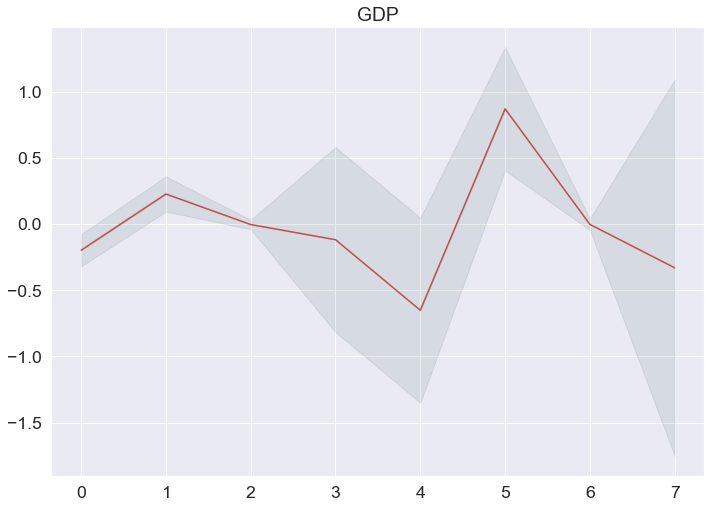

In [105]:
cumSums(res)

In [33]:
dataols.to_csv('stata.csv')

In [37]:
dataols.columns

Index(['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2', 'date',
       'OIS_SW', 'OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y',
       'OIS_4Y', 'OIS_5Y', 'OIS_6Y', 'OIS_7Y', 'OIS_8Y', 'OIS_9Y', 'OIS_10Y',
       'OIS_15Y', 'OIS_20Y', 'DE3M', 'DE6M', 'DE1Y', 'DE2Y', 'DE3Y', 'DE4Y',
       'DE5Y', 'DE6Y', 'DE7Y', 'DE8Y', 'DE9Y', 'DE10Y', 'DE15Y', 'DE20Y',
       'DE30Y', 'IT2Y', 'FR2Y', 'ES2Y', 'IT5Y', 'ES5Y', 'FR5Y', 'ES10Y',
       'FR10Y', 'IT10Y', 'STOXX50', 'SX7E', 'EURUSD', 'EURGBP', 'EURJPY', '1M',
       '3M', '6M', '1Y', '2Y', '5Y', '10Y', 'Date', 'ConfFactor1',
       'ConfFactor2', 'ConfFactor3', 'D1', 'D2', 'D3', 'D4'],
      dtype='object')

In [38]:
dfstata = dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2', 'D1', 'D2', 'D3', 'D4', var]]
dfstata.to_csv('stata.csv')

In [13]:
res.cov_params()

array([[ 0.00420411, -0.00845224,  0.00442274,  0.00994469, -0.00839968,
        -0.01372981,  0.01217121,  0.02026224],
       [-0.00845224,  0.01711369, -0.00908598, -0.02102274,  0.01877661,
         0.02737778, -0.0251215 , -0.04261997],
       [ 0.00442274, -0.00908598,  0.0050656 ,  0.01379507, -0.01493112,
        -0.01337816,  0.01454989,  0.02769299],
       [ 0.00994469, -0.02102274,  0.01379507,  0.11508923, -0.20815532,
         0.05924994,  0.03436405,  0.22967357],
       [-0.00839968,  0.01877661, -0.01493112, -0.20815532,  0.41068522,
        -0.17705638, -0.02651545, -0.4146807 ],
       [-0.01372981,  0.02737778, -0.01337816,  0.05924994, -0.17705638,
         0.17537895, -0.05728174,  0.11729357],
       [ 0.01217121, -0.0251215 ,  0.01454989,  0.03436405, -0.02651545,
        -0.05728174,  0.04964549,  0.06881873],
       [ 0.02026224, -0.04261997,  0.02769299,  0.22967357, -0.4146807 ,
         0.11729357,  0.06881873,  0.46572063]])

# Diagnostics

In [88]:
r_waldtest = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])
res.wald_test(r_waldtest)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[217.55943316]], p-value=1.2620982493573598e-42, df_denom=8>

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[196.92534158]], p-value=2.83901092844314e-38, df_denom=8>

In [69]:
r_testsum = [1, 1, 1, 1, 1, 1, 1, 1]
res.wald_test(r_testsum)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.02045168]], p-value=0.8862827779422086, df_denom=1>

In [100]:
dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2', 'ConfFactor2']].corr()

,Current Year,One Year Ahead,Rolling1,Rolling2,ConfFactor2
Current Year,1.000000,0.324060,0.347068,0.344816,0.005853
One Year Ahead,0.324060,1.000000,0.330951,0.337201,-0.004988
Rolling1,0.347068,0.330951,1.000000,0.738929,0.104802
Rolling2,0.344816,0.337201,0.738929,1.000000,0.121656
ConfFactor2,0.005853,-0.004988,0.104802,0.121656,1.000000


In [103]:
t1 = np.linalg.eig(inv_weights)[0]

In [106]:
t1 = [0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25, 1, 1]


In [108]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']].describe()

,Current Year,One Year Ahead,Rolling1,Rolling2
count,47.000,47.000,47.000,47.000
mean,-0.030,0.003,0.004,-0.012
std,1.018,0.349,0.529,0.146
min,-2.922,-0.834,-2.022,-0.460
25%,-0.234,-0.156,-0.166,-0.082
50%,-0.110,-0.033,-0.002,-0.022
75%,0.185,0.136,0.203,0.087
max,5.180,0.966,1.574,0.336


In [109]:
from scipy.stats import kurtosis
pd.DataFrame(kurtosis(dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']], fisher=False)).T

,0,1,2,3
0,17.095,3.882,8.460,4.140


In [110]:
from scipy.stats import skew
pd.DataFrame(skew(dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']])).T

,0,1,2,3
0,2.298,0.435,-0.282,-0.543
